In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import HTML
import matplotlib.animation as animation

import sac
import envs
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [36]:
logs_dir = '/checkpoint/linamezghani/offline-gcrl/logs/'

#exp_name = "20220420-030857_walker_oracleFalse-rs1.0-lr0.0005-bs2048-alpha0.008-gamma0.85-action_repeat2-1goal-grid_search"
exp_name = "20220510-105652_walker_graph_sig-reward-rs0.1-lr0.0003-bs2048-alpha0.01-gamma0.9-action_repeat2-1goal10"

%ls '{logs_dir}{exp_name}/agent'

checkpoint_0.pth    checkpoint_200.pth  checkpoint_400.pth
checkpoint_100.pth  checkpoint_300.pth


In [37]:
ckpt = 400
ckpt_path = f'{logs_dir}{exp_name}/agent/checkpoint_{ckpt}.pth'

In [38]:
tmp_path = f"{logs_dir}/multirun/{exp_name}"
cfg_path = f"{tmp_path}/{os.listdir(tmp_path)[0]}/.hydra/config.yaml"

cfg = OmegaConf.load(cfg_path)

print(cfg)
cfg.env.max_episode_steps=100

cfg.env.random_start_pos = False
print(OmegaConf.to_yaml(cfg.env))

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)

{'main': {'name': '${now:%Y%m%d-%H%M%S}_${env.id}_${main.suffix}', 'suffix': '${main.reward}-reward-rs${replay_buffer.reward_scaling}-lr${sac.optim.lr}-bs${sac.optim.batch_size}-alpha${sac.optim.entropy.alpha}-gamma${sac.optim.gamma}-action_repeat${env.action_repeat}-1goal${eval.goal_idx}', 'logs_dir': '/checkpoint/${env:USER}/offline-gcrl/logs/${main.name}', 'save_interval': 100, 'reward': 'graph_sig', 'run': None, 'load_from_dir': '/checkpoint/sainbar/offline-gcrl/logs/20220509-173335_walker_memonly_thresh2_neg0_skip0.05', 'train_until': 'policy'}, 'env': {'id': 'walker', 'success_thresh': 0.7, 'max_episode_steps': 1000, 'action_repeat': 2, 'random_start_pos': False, 'obs': {'type': 'vec', 'state_size': 18, 'vec_size': 24, 'rgb_size': 64}, 'action_dim': 6, 'obs_type': 'vec'}, 'exploration_buffer': {'data_dir': '/checkpoint/${env:USER}/offline-gcrl/data/walker/proto/buffer', 'num_procs': 10}, 'replay_buffer': {'capacity': 100000, 'reward_scaling': 0.1}, 'optim': {'num_epochs': 1001}, 

In [39]:
vis_cfg = cfg.copy()
env = envs.make_env(cfg.env, space_info)

if cfg.env.obs.type == 'vec':
    vis_cfg.env.obs.type = 'rgb'
    space_info_rgb = utils.get_space_info(vis_cfg.env.obs, vis_cfg.env.action_dim)
vis_env = envs.make_env(vis_cfg.env, space_info_rgb)

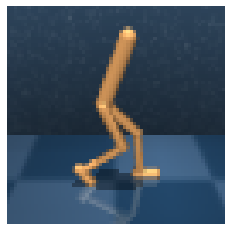

In [40]:
obs = vis_env.reset()
plt.imshow(obs['goal_obs'].transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [41]:
device=torch.device("cuda:0")
space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
agent = sac.SAC(cfg.sac, space_info, device)

agent.load_checkpoint(ckpt_path, evaluate=True)

Loading models from /checkpoint/linamezghani/offline-gcrl/logs/20220510-105652_walker_graph_sig-reward-rs0.1-lr0.0003-bs2048-alpha0.01-gamma0.9-action_repeat2-1goal10/agent/checkpoint_400.pth


In [32]:
def generate_episode_walker(env, goal_idx=None, vis=True, rnet_val=False):
    video = []
    if rnet_val:
        rewards = []
    state = env.reset(goal_idx=goal_idx)
    #print(env.get_goals()[env.get_goal_idx()])
    #print(rnet.memory.states[env.get_goal_idx()])
    if vis:
        img = env.get_image()
        video.append(np.concatenate((img, env.goals['rgb_obs'][env.goal_idx]), axis=2).transpose(1, 2, 0))
    for i in range(cfg.env.max_episode_steps//cfg.env.action_repeat):
        with torch.no_grad():
            action = agent.select_action(state.copy(), evaluate=True)
            #print(action)
        state, reward, done, info = env.step(action)
        if vis:
            img = env.get_image()
            video.append(np.concatenate((img, env.goals['rgb_obs'][env.goal_idx]), axis=2).transpose(1, 2, 0))
        if rnet_val:
            rewards.append(get_reward(rnet.model, state))
    if rnet_val:
        plt.plot(rewards)
        plt.grid()
        plt.plot([0]*len(rewards), ls='--', c='grey')
        plt.title('rnet value')
        plt.xlabel('step')
        plt.show()
    return info, np.array(video)

oracle_distance: 0.81
oracle_success: False


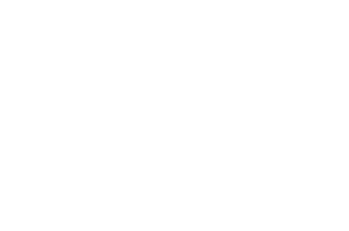

In [35]:
info, video = generate_episode_walker(env, goal_idx=8, vis=True, rnet_val=False)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())

oracle_distance: 2.054
oracle_success: False


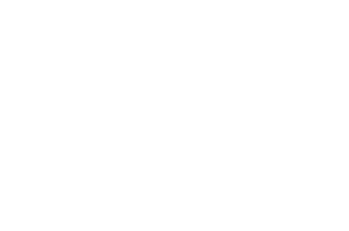

In [26]:
info, video = generate_episode_walker(env, goal_idx=8, vis=True, rnet_val=False)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())

oracle_distance: 1.624
oracle_success: False


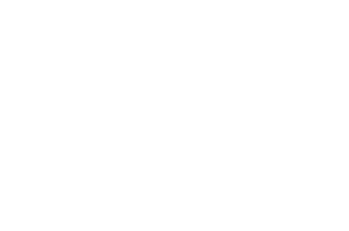

In [45]:
info, video = generate_episode_walker(env, goal_idx=10, vis=True, rnet_val=False)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())

oracle_distance: 1.614
oracle_success: False


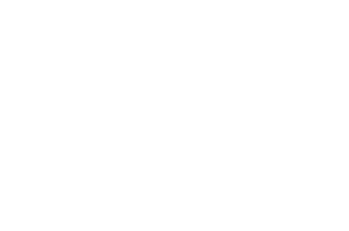

In [44]:
info, video = generate_episode_walker(env, goal_idx=10, vis=True, rnet_val=False)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())

In [113]:
from rnet.memory import RNetMemory
import rnet.utils as rnet_utils
import envs.walker_utils as walker_utils

memory = RNetMemory(cfg.rnet.memory, space_info, cfg.rnet.model.feat_size, device)

exp_name = 'walker_thresh2'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)
memory, NN = rnet_utils.load(save_dir, memory)

Loading rnet objects from  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2


In [123]:
goals = memory.get_goals()
print(goals)

{'state': array([[ 0.        ,  0.        , -1.30436728, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.0273921 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.74151532,  0.06582605,  2.64152777, ..., -7.10769666,
         1.82391028,  4.31500706],
       ...,
       [-0.30595146,  8.04389816, 12.23921904, ..., -0.91404087,
         8.5442962 , -5.49427009],
       [-1.22291485, -4.14561041, -8.02359307, ...,  2.98596679,
        -3.90158759, 29.64162658],
       [-0.68360663,  6.72339859,  0.42243664, ..., -1.96325124,
         7.28456845, -4.37858104]]), 'vec_obs': array([[ 0.26328817, -0.9647172 , -0.3070977 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.9934862 ,  0.11395248, -0.9990543 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.87755144,  0.47948247, -0.9899197 , ..., -7.1076965 ,
         1.8239102 ,  4.315007  ],
       ...,
       [ 0.9469615 , -0.321347  ,  0.99253595, ..., -

In [124]:
n = goals['vec_obs'].shape[0]
goals['rgb_obs'] = np.zeros((n, 3, 64, 64), dtype=np.uint8)
for i in range(n):
    state = goals['state'][i]
    obs = walker_utils.get_state_from_lexa(env, state[:9])
    goals['rgb_obs'][i] = env.get_image_from_obs(obs)

In [128]:
env.set_goals(goals)

In [126]:
goals['state'] = goals['state'][:, :9]

In [127]:
goals['state'].shape

(341, 9)